# Abtract

(To be completed!)

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

# Read files

We obtained 12-month worth of citi bike trip data, from 2018.04 to 2019.03. Each month worth of data is in a .csv file, and here we will append them into one dataframe, which adds up to about 18 million records of trips.

In [2]:
l = []
for s in ['201804', '201805', '201806', '201807', '201808', '201809', '201810','201811', '201812', '201901', '201902','201903']:
    df = pd.read_csv('/Users/yhong/Documents/data/citibike/'+s+'-citibike-tripdata.csv')
    l.append(df)
df = pd.concat(l)

What kind of information does the dataset have? Here are its columns (fields), size (shape), and a taste of the first 5 rows:

In [3]:
display(df.columns)
display(df.shape)
display(df.head())

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

(18248550, 15)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,840,2018-04-01 03:07:39.0700,2018-04-01 03:21:39.1280,72.0,W 52 St & 11 Ave,40.767272,-73.993929,379.0,W 31 St & 7 Ave,40.749156,-73.991600,31977,Subscriber,1973,1
1,1438,2018-04-01 07:20:02.2150,2018-04-01 07:44:00.5690,72.0,W 52 St & 11 Ave,40.767272,-73.993929,426.0,West St & Chambers St,40.717548,-74.013221,21403,Subscriber,1956,1
2,219,2018-04-01 08:11:14.4060,2018-04-01 08:14:53.7880,72.0,W 52 St & 11 Ave,40.767272,-73.993929,447.0,8 Ave & W 52 St,40.763707,-73.985162,29081,Subscriber,1974,1
3,410,2018-04-01 08:52:32.3730,2018-04-01 08:59:23.2190,72.0,W 52 St & 11 Ave,40.767272,-73.993929,173.0,Broadway & W 49 St,40.760683,-73.984527,32130,Subscriber,1983,1
4,485,2018-04-01 09:37:34.3270,2018-04-01 09:45:39.9980,72.0,W 52 St & 11 Ave,40.767272,-73.993929,3159.0,W 67 St & Broadway,40.774925,-73.982666,30055,Subscriber,1978,1


As shown above, for each trip, the record contains the start time, end time, duration of the trip, the station id, name, latitude, and longitude for the start and end stations, the id of the bike, as well as information on the rider: their gender, birth year, and user type (subscriber or customer.) 

To make our lives easier, we'll convert the start and end time columns to datetime objects.

In [7]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Cleaning

Our first step is to clean the data. But before that, we need to make some assumption based on how the data is collected. We're going to assume that each time a bike is checked out, the trip start time, location, and bike id is automatically recorded; similarly, when the bike is checked back in after the trip, the end time and location is recorded. Ideally, each station will map to a unique station name, id, and location coordinates, but we will see that that is not actually the case -- and we'll figure out how to handle it. The rider information, on the other hand, we will assumed to be less accurate, since it is self-reported by the user -- for a "Customer", perhaps at the start of the rider, and for a "Subscriber", perhaps online. Our analysis later will prove that this is the case.

## Nan values

First, we'll take a look at the null values in our data.

In [9]:
df.isna().sum()

tripduration                  0
starttime                     0
stoptime                      0
start station id           2534
start station name         2534
start station latitude        0
start station longitude       0
end station id             2534
end station name           2534
end station latitude          0
end station longitude         0
bikeid                        0
usertype                      0
birth year                    0
gender                        0
dtype: int64

In [5]:
df[df['start station id'].isna()].head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
875757,2544,2018-08-15 11:31:37.8670,2018-08-15 12:14:02.1290,NaN,NaN,40.857,-73.890,NaN,NaN,40.857,-73.890,34426,Subscriber,1971,2
875936,2004,2018-08-15 11:35:26.0140,2018-08-15 12:08:50.0360,NaN,NaN,40.857,-73.890,NaN,NaN,40.857,-73.887,34428,Subscriber,1976,2
877673,213,2018-08-15 12:10:37.4360,2018-08-15 12:14:11.2920,NaN,NaN,40.857,-73.890,NaN,NaN,40.857,-73.890,34428,Subscriber,1976,2
877907,602,2018-08-15 12:15:17.3330,2018-08-15 12:25:19.7620,NaN,NaN,40.845,-73.902,NaN,NaN,40.857,-73.890,34525,Subscriber,1988,1
879270,511502,2018-08-15 12:41:41.9690,2018-08-21 10:46:44.6440,NaN,NaN,40.857,-73.890,NaN,NaN,40.857,-73.890,34548,Subscriber,1986,1


It appears that there are a number (2534, to be exact) of records without start and end stations - as in, the coordinates are recorded and are representing different locations, but the station id and station names are missing. This is likely a data recording issue; if we wish, we could reconcile this by checking if the coordinates match with any other named stations, or simply assign new station and ids for each unique location coordinate. Or, depending on the question we want to answer, we can ignore these entries. After all, they account for ~0.01% of our dataset.

Looking at the station mapping and plotting out the coordinate locations will help us decide what to do with these null values.

## Unique stations

We want to get a sense of how the station id, name, and coordinates are mapped to each other. As an initial check, we obtain the unique number of start station ids, names, and coordinates.

In [18]:
st = list(set(zip(df['start station longitude'], df['start station latitude'])))
display(len(st))

stid = list(set(df['start station id']))
display(len(stid))

stnm = list(set(df['start station name']))
display(len(stnm))

930

3362

831

Uh oh. There appears to be more coordinates and ids than station names. Something must be going on.

In [19]:
ed = list(set(zip(df['end station longitude'], df['end station latitude'])))
display(len(ed))

edid = list(set(df['end station id']))
display(len(edid))

ednm = list(set(df['end station name']))
display(len(ednm))

965

3394

863

Similarly, the end station mapping doesn't seem to be 1-1 and onto. And there appears to be more end stations represented than start stations.

We will resort to plotting some of these coordinates to find out where they actually are.

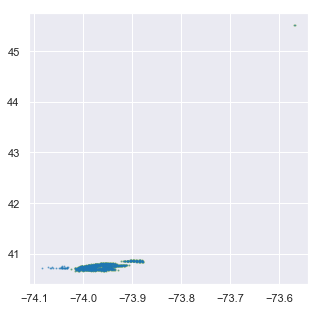

In [22]:
sns.set()
plt.figure(figsize = (5, 5))
plt.scatter(*zip(*st), color = 'yellow', marker = 'o', alpha = 0.5, s = 1)
plt.scatter(*zip(*ed), color = 'tab:blue', marker = 'o', alpha = 0.5, s = 1)

Yikes! That blue dot on the upper right corner does not look right. After a real-life coordinate check, we find out that it in fact represents a "station" in Montreal... Imagine what could be the story of that trip. On the other hand, we could vaguely make out a shape of Manhattan from the lower left blob of the plot. We will take more advantage of this as we zoom in on this part.

(40.6, 40.9)

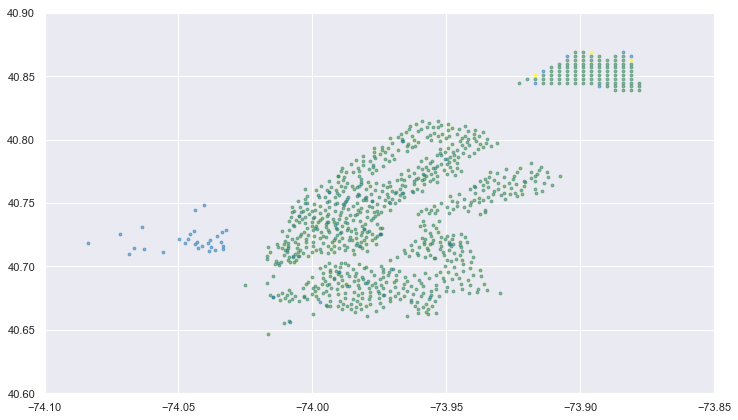

In [23]:
plt.figure(figsize = (12, 7))
plt.scatter(*zip(*st), color = 'yellow', marker = 'o', alpha = 0.5, s = 8)
plt.scatter(*zip(*ed), color = 'tab:blue', marker = 'o', alpha = 0.5, s = 8)
plt.xlim(-74.1, -73.85)
plt.ylim(40.6, 40.9)

Now you can tell which cluster is Manhattan -- and even the emptiness in the middle that is central park! The other components represent stations in Brooklyn, Queens, and other surrounding burroughs. 

There is a rather orderly looking blob on the upper right; we dug up the data and find out that these are in fact the records with null station names and ids. Mystery solved! We will remove these records from our dataset.

Notice that there are some scattered blue points on the left side. These stations are located in Jersey. They are colored blue because the trips ended there, but no trips started from those stations. (The stations that are both represented in start stations and end stations are green, since green = blue + yellow.) This is because our dataset contains only trips that started from stations in New York. There is a separate dataset that contains all trips started from stations in Jersey. For our purposes, we will only consider trips that start and end in New York, so we will remove these records from our dataset.

(40.625, 40.825)

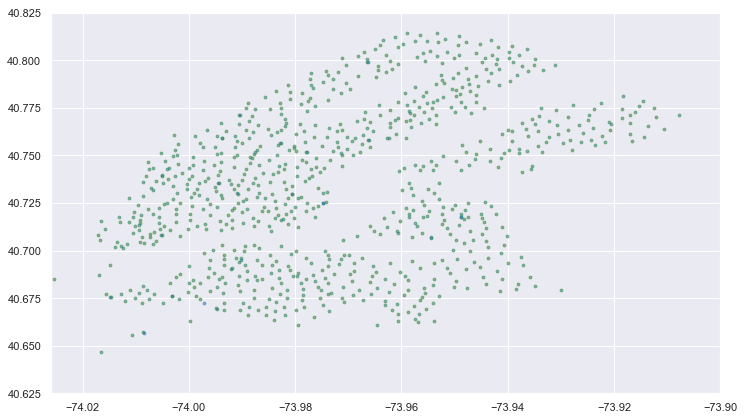

In [29]:
plt.figure(figsize = (12, 7))
plt.scatter(*zip(*st), color = 'yellow', marker = 'o', alpha = 0.5, s = 8)
plt.scatter(*zip(*ed), color = 'tab:blue', marker = 'o', alpha = 0.5, s = 8)
plt.xlim(-74.026, -73.90)
plt.ylim(40.625, 40.825)

This is our final version of coordinates considered! We determined the cutoffs for the coordinates based on the plot above. We are happy that most points are green, with a few exceptions.

In [30]:
df = df[(df['start station latitude'].between(40.625, 40.825))&(df['start station longitude'].between(-74.026, -73.90))
   &(df['end station latitude'].between(40.625, 40.825))&(df['end station longitude'].between(-74.026, -73.90))]

After this round of cleaning, we tally the number of nulls again, as well as unique number of start and stations.

In [32]:
display(df.isna().sum())

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

In [35]:
No more nulls!

SyntaxError: invalid syntax (<ipython-input-35-dc3f5b814336>, line 1)

In [33]:
st = list(set(zip(df['start station longitude'], df['start station latitude'])))
display(len(st))

stid = list(set(df['start station id']))
display(len(stid))

stnm = list(set(df['start station name']))
display(len(stnm))

828

826

828

In [34]:
ed = list(set(zip(df['end station longitude'], df['end station latitude'])))
display(len(ed))

edid = list(set(df['end station id']))
display(len(edid))

ednm = list(set(df['end station name']))
display(len(ednm))

831

829

831

The number of station id and coordinates are similar, but still inconsistent. A quick look at the mapping tells us that certain stations appeared to have changed names, ids, and/or coordinates throughout the year. 

In [36]:
ids = df[['start station longitude', 'start station latitude','start station id', 'start station name']].drop_duplicates().groupby(['start station name'])['start station id'].count().reset_index()
ids[ids['start station id']!=1]

,start station name,start station id
15,11 Ave & W 59 St,2
330,E 13 St & Avenue A,2
448,Frost St & Meeker Ave,2
489,Henry St & W 9 St,2
729,W 13 St & 5 Ave,2
769,W 45 St & 6 Ave,2


In [46]:
ids = df[['start station longitude', 'start station latitude','start station id', 'start station name']].drop_duplicates().groupby(['start station id'])['start station name'].count().reset_index()
df[df['start station id'].isin(list(ids[ids['start station name']!=1]['start station id']))][['start station id', 'start station name', 'start station longitude', 'start station latitude']].drop_duplicates().sort_values(by ='start station id')

,start station id,start station name,start station longitude,start station latitude
96866,253.0,W 13 St & 5 Ave,-73.994539,40.735439
868,253.0,W 13 St & 5 Ave -moved to 5947.04,-73.994539,40.735439
420033,433.0,E 13 St & Avenue A,-73.980572,40.729554
1,433.0,old - E 13 St & Avenue A,-73.980572,40.729554
730288,530.0,11 Ave & W 59 St,-73.990541,40.771522
306,530.0,11 Ave & W 59 St,-73.990460,40.771497
1130942,3040.0,GOW Tech Shop,-73.994980,40.669800
986988,3040.0,Handlebar @ Gowanus,-73.994980,40.669800
986597,3243.0,E 58 St & 1 Ave,-73.962262,40.758924
708,3243.0,E 58 St & 1 Ave (NE Corner),-73.962262,40.758924


We won't go into too many details here. But for the sake of simplicity, we will henceforth assume that no matter how the station id and names change, the coordinates (latitude, longitude) will uniquely represent the start location.

## Old and new stations

As one can imagine, throughout the year, some stations will close, and new ones will open. There is no great way to know exactly, since we can only assume from the first and last trips from stations. If we were looking for a station-specific analyses, we may want to exclude ones that appear to have later start dates, or early last trip dates.

In [48]:
df.groupby(['start station name'])['starttime'].first().sort_values(ascending = False).head()

start station name
Lexington Ave & E 36 St         2019-03-13 11:04:13.4130
E 58 St &  1 Ave (NW Corner)    2019-03-08 10:18:18.9130
6 Ave & Broome St               2019-03-07 12:47:43.6160
E 84 St & 3 Ave                 2019-03-04 12:42:54.5370
E 58 St & 1 Ave (NE Corner)     2019-03-01 06:04:55.6880
Name: starttime, dtype: object

In [49]:
df.groupby(['start station name'])['starttime'].last().sort_values(ascending = True).head()

start station name
Warren St & Church St    2018-04-10 09:05:58.7550
Greenwich Ave & 8 Ave    2018-04-12 08:25:40.7350
E 41 St & 5 Ave          2018-04-16 00:43:04.9120
E 95 St & 3 Ave          2018-05-03 11:36:36.5280
W 13 St & Hudson St      2018-05-11 12:02:49.4400
Name: starttime, dtype: object

## Same start & end

And there are also the cases where a record starts and ends at the same station. The dataset has already filtered out those trips that last less than 60s and start/end at the same station. If we were to use these record as a proxy for trips (i.e. using the bike to go from one place to another), we would filter out these records.

In [50]:
df[df['start station name']==df['end station name']].sort_values(by = 'tripduration').head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
342194,61,2019-01-10 17:14:37.1740,2019-01-10 17:15:38.3210,517.0,Pershing Square South,40.751581,-73.977910,517.0,Pershing Square South,40.751581,-73.977910,34033,Subscriber,1979,1
367106,61,2018-11-07 20:02:38.7930,2018-11-07 20:03:40.5430,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985,34317,Subscriber,1982,1
1237539,61,2018-06-12 17:55:52.7070,2018-06-12 17:56:54.2430,3088.0,Union Ave & Jackson St,40.716075,-73.952029,3088.0,Union Ave & Jackson St,40.716075,-73.952029,25020,Subscriber,1980,2
1235843,61,2018-06-13 09:07:36.5490,2018-06-13 09:08:37.6310,3087.0,Metropolitan Ave & Meeker Ave,40.714133,-73.952344,3087.0,Metropolitan Ave & Meeker Ave,40.714133,-73.952344,19550,Subscriber,1985,1
1072372,61,2019-03-27 10:28:16.6790,2019-03-27 10:29:17.8770,3231.0,E 67 St & Park Ave,40.767801,-73.965921,3231.0,E 67 St & Park Ave,40.767801,-73.965921,34811,Subscriber,1993,2


## Trip duration

We can find some huge outliers by looking at the trip duration column. What could have happened in a bike's 10283682s-long journey? One can only imagine -- it could be a stolen bike case, or a bike gone to repair -- regardless, not a great proxy for a bike trip.

In [52]:
df.sort_values(by = 'tripduration', ascending = False).head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
353727,10283682,2018-05-05 13:46:13.0220,2018-09-01 14:20:55.7330,343.0,Clinton Ave & Flushing Ave,40.697940,-73.969868,3081.0,Graham Ave & Grand St,40.711863,-73.944024,24939,Customer,1969,0
673036,10172645,2018-04-25 22:51:23.8620,2018-08-21 16:35:29.8510,514.0,12 Ave & W 40 St,40.760875,-74.002777,458.0,11 Ave & W 27 St,40.751396,-74.005226,17655,Subscriber,1978,1
1747315,9234953,2018-05-21 17:39:07.2160,2018-09-05 14:55:01.1670,3590.0,Carroll St & Franklin Ave,40.667941,-73.958800,3245.0,NYCBS DEPOT - DELANCEY,40.716444,-73.982331,27183,Customer,1982,0
314058,7667589,2018-04-01 14:22:47.8970,2018-06-29 08:15:57.3130,379.0,W 31 St & 7 Ave,40.749156,-73.991600,497.0,E 17 St & Broadway,40.737050,-73.990093,28287,Customer,1967,2
1284239,7624862,2018-04-13 14:36:49.9380,2018-07-10 20:37:52.5830,3649.0,W 129 St & Convent Ave,40.814394,-73.953247,3435.0,Grand St & Elizabeth St,40.718822,-73.995960,17094,Customer,1988,2


But fret not, the number of records with trip duration under 7200s (2 hours) make up 99.7% of all records.

In [54]:
df[df['tripduration']<7200].shape[0]/df.shape[0]

0.997039434093346

Plotting all trips under 2 hours, we see that most trips are in fact under half an hour.

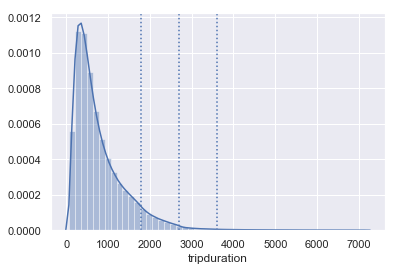

In [55]:
sns.distplot(df[df['tripduration']<7200]['tripduration'], bins = 50)
plt.axvline(1800, linestyle = ':')
plt.axvline(2700, linestyle = ':')
plt.axvline(3600, linestyle = ':')

# Calc speed

Another way to detect outliers is by looking at the average speed of the rider. Wait, but speed isn't in the data? Let's try to calculate that.

In [66]:
import math

We first estimate the distance between the start and end stations based on their coordinates. We take the two coordinates, and calculate a (wait for it) Manhattan distance between them, which is just the L-1 norm, since the streets and avenues in Manhattan are generally orthogonal. This is going to be a very rough estimate, since we have no way of knowing whether the rider traveled the shortest distance, or if there are indeed orthogonal paths between the start and end stations. Alternatively, we could have pulled data from a Google map API to get the exact shortest route between two coordinate points, but for our purposes, we chose not to go that route.

Here are two helper functions to calculate distance between two coordinates based on the Haversine function:

In [62]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [63]:
def manhattan(coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    c = (x1, y2)
    return haversine(coord1, c)+ haversine(c, coord2)

We then calculate the distance based on the start and end coordinates. To speed up the process, we calculate the distances for unique combinations of start and end stations, the. merge it onto our original dataframe.

In [67]:
tps = df[['start station longitude', 'start station latitude', 'end station longitude', 'end station latitude']].drop_duplicates()
tps['start'] = tps.apply(lambda x: (x['start station latitude'], x['start station longitude']), axis = 1)
tps['end'] = tps.apply(lambda x: (x['end station latitude'], x['end station longitude']), axis = 1)
tps['distance'] = tps.apply(lambda x: manhattan(x['start'], x['end']), axis = 1)
tps = tps[['start station longitude', 'start station latitude', 'end station longitude', 'end station latitude', 'distance']]
df = df.merge(tps, left_on =['start station longitude', 'start station latitude', 'end station longitude', 'end station latitude'], right_on = ['start station longitude', 'start station latitude', 'end station longitude', 'end station latitude'], how = 'left')

We then calculated speed = distance/tripduration. The unit is in m/s.

In [68]:
df['speed'] = df['distance']/df['tripduration']

In [74]:
df.sort_values(by = 'speed', ascending = False).head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,distance,speed
9716517,170,2018-09-13 19:25:41.9660,2018-09-13 19:28:32.4440,3508.0,St Nicholas Ave & Manhattan Ave,40.809725,-73.953149,3180.0,Brooklyn Bridge Park - Pier 2,40.698780,-73.997120,26119,Subscriber,1988,1,16041.725152,94.363089
9753069,161,2018-09-14 11:41:26.1340,2018-09-14 11:44:07.4680,3180.0,Brooklyn Bridge Park - Pier 2,40.698780,-73.997120,3374.0,Central Park North & Adam Clayton Powell Blvd,40.799484,-73.955613,30636,Subscriber,1993,1,14701.059083,91.310926
8103112,69,2018-08-18 17:45:21.6580,2018-08-18 17:46:31.2230,376.0,John St & William St,40.708621,-74.007222,3635.0,W 36 St & 9 Ave,40.754623,-73.995168,14626,Subscriber,1976,1,6132.923595,88.882951
8125512,88,2018-08-19 11:47:18.2450,2018-08-19 11:48:46.7090,3635.0,W 36 St & 9 Ave,40.754623,-73.995168,376.0,John St & William St,40.708621,-74.007222,32339,Subscriber,1975,1,6132.221201,69.684332
9701190,253,2018-09-13 17:25:22.5990,2018-09-13 17:29:36.5400,3533.0,St. Nicholas Ave & W 126 St,40.811432,-73.951878,3180.0,Brooklyn Bridge Park - Pier 2,40.698780,-73.997120,31186,Subscriber,1990,1,16338.557270,64.579278


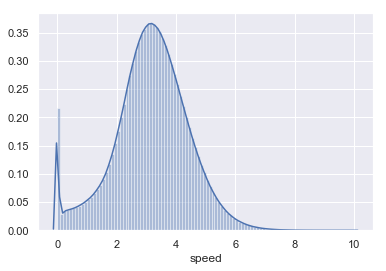

In [73]:
sns.distplot(df[df['speed']<=10]['speed'], bins = 100)

Taking a look at the distribution of speeds, we see that it looks quite like a normal distribution, with a bump closer to 0, and a tail on the right. 

# Final cleanse

Based on our previous analysis on trip duration and speed, we decided on top of our filtered data to keep only records with trip duration less than 2 hours, distance greater than 0 (different start and end points), and speed under 10 m/s. This will be our "trips" dataset, in which we use records as a proxy for bike trips taken by riders. 

In [ ]:
trips = df[(df['distance']>0)&(df['speed']<10)&(df['tripduration']<7200)]